In [ ]:
#OpenCV install
!pip install opencv-python==4.5.5.64

In [ ]:
!pip show opencv-python

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main_parser.py", line 8, in <module>
    from pip._internal.cli import cmdoptions
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/cmdoptions.py", line 23, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/parser.py", line 12, in <module>
    from pip._internal.configuration import Configuration, ConfigurationError
  File "/usr/local/lib/python3.7/dist-packages/pip/_intern

In [ ]:
#Importing and mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Copying data from google drive folder to local drive folder
%cp '/content/drive/MyDrive/CW_Dataset.zip' '/content/'
%cd '/content'
!unzip 'CW_Dataset.zip'

/content
Archive:  CW_Dataset.zip
replace CW_Dataset/labels/list_label_test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Library imports for image processing/machine learning and evalation metrics
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
%matplotlib inline
import numpy as np
import cv2
import pandas as  pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
#Setting paths for training and testing data and labels
train_path = 'CW_Dataset/train/'
test_path = 'CW_Dataset/test/'
train_labels = 'CW_Dataset/labels/list_label_train.txt'
test_labels = 'CW_Dataset/labels/list_label_test.txt'

#Initializing empty lists for training and testing data along with labels
X_train,y_train = [],[]
X_test,y_test = [],[]

#Reading training labels from CSV file and setting index and column names
train_labels = pd.read_csv(train_labels,sep=' ',header=None)
train_labels = train_labels.set_index(0)
train_labels.columns = ['label']

#Reading test labels from CSV file and setting index and column names
test_labels = pd.read_csv(test_labels,sep=' ',header=None)
test_labels = test_labels.set_index(0)
test_labels.columns = ['label']

#Reading training images
print("Reading Training images...")
for img in os.listdir(train_path):
  img_path = os.path.join(train_path,img)
  if img_path.endswith('.jpg'):
    X_train.append(cv2.imread(img_path))
    p = img.split('_aligned')[0]+'.jpg'
    y_train.append(train_labels.loc[p].values[0])

#Reading test images
print("Reading Test images...")
for img in os.listdir(test_path):
  img_path = os.path.join(test_path,img)
  if img_path.endswith('.jpg'):
    X_test.append(cv2.imread(img_path))
    p = img.split('_aligned')[0]+'.jpg'
    y_test.append(test_labels.loc[p].values[0])

#Converting lists to numpy arrays
X_train,X_test = np.array(X_train),np.array(X_test)
y_train,y_test = np.array(y_train),np.array(y_test)

print("Done!")

Reading Training images...
Reading Test images...
Done!


In [ ]:
print((X_train.shape))
print((y_train.shape))
print((X_test.shape))
print((y_test.shape))

(12271, 100, 100, 3)
(12271,)
(3068, 100, 100, 3)
(3068,)


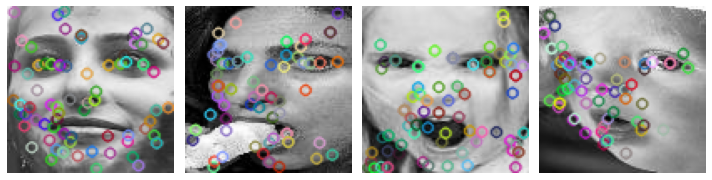

In [ ]:
#Initiate SIFT detector
sift = cv2.SIFT_create()

#Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(X_train)):
#Identify keypoints and extract descriptors with SIFT
img = img_as_ubyte(color.rgb2gray(X_train[i]))
kp, des = sift.detectAndCompute(img, None)

#Show results for first 4 images
    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

#Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

fig.tight_layout()
plt.show()

#Convert to array for easier handling
des_array = np.vstack(des_list)

In [ ]:
#Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10

#Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

In [ ]:
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

In [ ]:
#Initialising SVM classifier with specified parameters
classifier = svm.SVC(C= 0.8, kernel='poly')

#Fitting the classifier using histograms of codewords and corresponding labels
classifier.fit(hist_array, y_train_list)

SVC(C=0.8, kernel='poly')

In [ ]:
#Create a classifier: a support vector classifier
classifier = svm.SVC(kernel='rbf')

#We learn the digits on the first half of the digits
classifier.fit(hist_array, y_train_list)

SVC()

In [ ]:
#Generating histograms of codewords for test images using the trained KMeans model
hist_list = []

#Looping through test images
for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

#Checking if descriptors are available
    if des is not None:
        hist = np.zeros(k)

#Predicting codeword indices using the trained KMeans model
        idx = kmeans.predict(des)

#Creating histograms for each test image
        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        hist_list.append(hist)

    else:
        hist_list.append(None)

#Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [ ]:
#Making predictions on test data
y_pred = classifier.predict(hist_array).tolist()

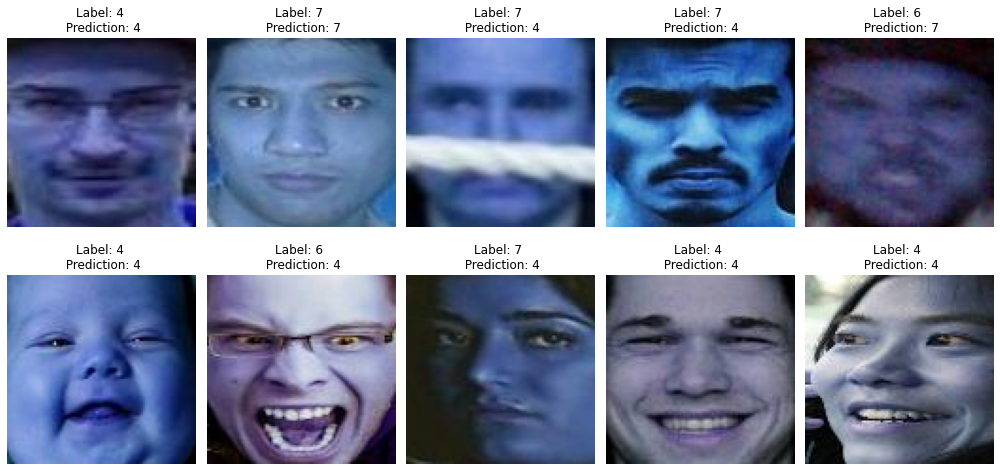

In [ ]:
#Visualizing a subset of test images along with their actual labels and predicted labels
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

#Looping through the first 10 test images
for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
#Classification Report
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

           1       0.46      0.08      0.14       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.43      0.87      0.58      1183
           5       0.25      0.03      0.05       478
           6       0.00      0.00      0.00       161
           7       0.36      0.30      0.33       680

    accuracy                           0.42      3065
   macro avg       0.22      0.18      0.16      3065
weighted avg       0.34      0.42      0.32      3065




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


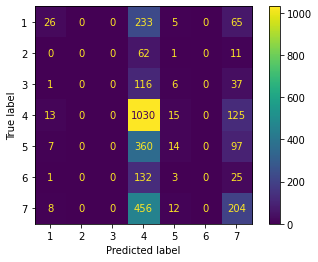

In [ ]:
#Confusion Matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
#Saving the trained SVM classifier with SIFT features using pickle
import pickle
filename = 'svm_with_sift.sav'
pickle.dump(classifier, open(filename, 'wb'))